<a href="https://colab.research.google.com/github/SiyuanChen726/BreastAgeNet/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/SiyuanChen726/BreastAgeNet.git

Cloning into 'BreastAgeNet'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 295 (delta 65), reused 8 (delta 7), pack-reused 165 (from 1)
Receiving objects: 100% (295/295), 24.67 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [ ]:
!apt-get update
!apt-get install -y openslide-tools libopenslide0
!pip install openslide-python

In [ ]:
# Download the files with corrected Google Drive links
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1tDfFXZvB6PASPW-4OMrBU-HQo7optH53' -O 'BreastAgeNet_bestModel.pt'

--2024-11-30 06:15:45--  https://drive.google.com/uc?export=download&id=1tDfFXZvB6PASPW-4OMrBU-HQo7optH53
Resolving drive.google.com (drive.google.com)... 74.125.68.139, 74.125.68.138, 74.125.68.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.68.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1tDfFXZvB6PASPW-4OMrBU-HQo7optH53&export=download [following]
--2024-11-30 06:15:45--  https://drive.usercontent.google.com/download?id=1tDfFXZvB6PASPW-4OMrBU-HQo7optH53&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.175.132, 2404:6800:4003:c1c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.175.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9995011 (9.5M) [application/octet-stream]
Saving to: ‘BreastAgeNet_bestModel.pt’

BreastAgeNet_bestMo 100%[===================>]   9.53M 

In [2]:
import os
import sys
sys.path.append('/scratch_tmp/users/k21066795/BreastAgeNet')


import h5py
import openslide
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


from utils_vis import *
from utils_train import *

In [3]:
ckpt_name = "/scratch_tmp/users/k21066795/BreastAgeNet/data/epi0.9_UNI_250_MultiHeadAttention_bestModel.pt"
n_feats = get_dim_input(model_name = "UNI")

model = BreastAgeNet(n_feats, attention="MultiHeadAttention", n_classes=3, n_heads=8, n_latent=512, embed_attn=True)
model.load_state_dict(torch.load(ckpt_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

/tmp/ipykernel_958510/97948491.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_name))


cuda


In [ ]:
clinic_df = pd.read_csv("/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/DATA/clinicData/AllCohorts.csv")
clinic_df = clinic_df.loc[clinic_df["cohort"]=="UR", :].copy()

valid_patches = []
for fea_pt in clinic_df.h5df.values:
    with h5py.File(fea_pt, "r") as file:
        bag = np.array(file["embeddings"])
        bag = np.squeeze(bag)
        img_id = np.array(file["patch_id"])
    img_id = [i.decode("utf-8") for i in img_id]
    bag_df = pd.DataFrame(bag)
    bag_df.index = img_id

    csv_pt =  os.path.join(Path(fea_pt).parent, Path(fea_pt).stem.split('_bagFeature_')[0]+'_patch.csv')
    df = pd.read_csv(csv_pt)
    valid_id = list(df['patch_id'][df['TC_epi'] > 0.9])
    valid_id = list(set(valid_id) & set(bag_df.index))
    valid_patches.extend(valid_id)
print(len(valid_patches))

valid_wsis = ["_".join(i.split("_")[:3]) for i in valid_patches]
print(len(np.unique(valid_wsis)))

a, b = np.unique(valid_wsis, return_counts=True)
filtered_a = [i for i, count in zip(a, b) if count >= 5]
print(len(filtered_a))
print(len(np.unique([i.split("_")[0] for i in filtered_a])))
clinic_df = clinic_df[clinic_df["wsi_id"].isin(filtered_a)]
print("Filtered DataFrame length:", len(clinic_df))
print("Unique age groups and counts:", np.unique(clinic_df["age_group"], return_counts=True))


print(len(valid_patches))
valid_patches = [i for i in valid_patches if "_".join(i.split("_")[:3]) in filtered_a]
print(len(valid_patches))


df = clinic_df.copy() # file containing all {wsi_id}_UNI.h5 files for the dataset
df['h5df'] = [Path(i) for i in df["h5df"]]

valid_patches = valid_patches # select patches with TC_epi > 0.9
test_dblock = DataBlock(blocks = (TransformBlock, CategoryBlock),
               get_x = ColReader('h5df'),
               get_y = ColReader('age_group'),
               item_tfms = MILBagTransform(df.h5df, bag_size, valid_patches))

test_dls = test_dblock.dataloaders(df, bs=bag_size, shuffle=False)
dataloaders = test_dls.test_dl(df, with_labels=True)

In [ ]:
# Initialize test loader, assume clinic_df is pre-defined
phase = 'test'
model.eval()

outputs = pd.DataFrame()  # Initialize empty DataFrame
for _ in range(10):
    for (patch_ids, inputs), labels in tqdm(dataloaders):
        patch_ids = np.array(patch_ids)  # (150, 7)
        patch_ids = np.transpose(patch_ids)  # Now shape is (7, 150)
        patch_ids = patch_ids.flatten()  # Flattened to shape (1050,)
    
        with torch.set_grad_enabled(phase == 'train'):
            logits, embeddings, attentions = model(inputs)
            attentions = attentions.view(-1, attentions.shape[-1])  # Flatten attentions: [X, 3]
            embeddings = embeddings.view(-1, embeddings.shape[-1])  # Flatten embeddings: [X, 512]
            
            # Ensure logits are repeated across the batch and bag_size
            # logits.shape is [batch_size, 3], so we need to repeat for each patch in the batch
            batch_size = inputs.size(0)
            bag_size = attentions.size(0) // batch_size  # Calculate bag_size
            logits = logits.repeat(bag_size, 1)  # Repeat logits across the bag size: [X, 3]
    
        # Concatenate patch_ids, embeddings, and attentions
        # Assuming patch_ids, embeddings, and attentions are of compatible shapes
        combined_data = np.column_stack((patch_ids, embeddings.cpu().numpy(), logits.cpu().numpy(), attentions.cpu().numpy()))  # Convert to numpy
        
        # Create a DataFrame and add to the output
        dfi = pd.DataFrame(combined_data, columns=['patch_id'] + [f'embedding_{i}' for i in range(embeddings.shape[1])] + [f'branch_{i}' for i in range(logits.shape[1])] + [f'attention_{i}' for i in range(attentions.shape[1])])
        
        # Append new data to the main dataframe
        outputs = pd.concat([outputs, dfi], axis=0)  # Append new data to the main dataframe

In [27]:
# Remove duplicates from the final DataFrame
outputs = outputs.drop_duplicates()
outputs["wsi_id"] = [i.split("_")[0] for i in list(outputs["patch_id"])]
outputs = pd.merge(outputs, clinic_df, on="wsi_id")
outputs.columns[-20:]

Index(['embedding_506', 'embedding_507', 'embedding_508', 'embedding_509',
       'embedding_510', 'embedding_511', 'branch_0', 'branch_1', 'branch_2',
       'attention_0', 'attention_1', 'attention_2', 'repeat', 'wsi_id',
       'patient_id', 'cohort', 'source', 'age', 'age_group', 'h5df'],
      dtype='object')

In [49]:
averaged_data = get_averaged_outputs(outputs)
averaged_data

,wsi_id,patient_id,cohort,source,age,age_group,branch_0,branch_1,branch_2,sigmoid_0,sigmoid_1,sigmoid_2,binary_0,binary_1,binary_2,final_prediction
0,17064108_FPE_3,17064108.0,KHP,RM,29.0,0.0,-0.114657,-1.054836,-6.016745,0.471367,0.258297,0.002432,0,0,0,0
250,17064108_FPE_4,17064108.0,KHP,RM,29.0,0.0,-0.136174,-0.366666,-4.847438,0.466009,0.409347,0.007787,0,0,0,0
500,17064108_FPE_2,17064108.0,KHP,RM,29.0,0.0,-0.085772,-1.570717,-5.459953,0.478570,0.172114,0.004236,0,0,0,0
750,17064108_FPE_1,17064108.0,KHP,RM,29.0,0.0,0.100617,-0.836838,-5.992000,0.525133,0.302201,0.002492,1,0,0,1
1000,17064108_FPE_5,17064108.0,KHP,RM,29.0,0.0,0.203724,-1.009123,-4.647745,0.550756,0.267152,0.009492,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22444,19004666_FPE_3,19004666.0,KHP,RM,41.0,1.0,1.672026,-0.877469,-2.385076,0.841846,0.293703,0.084318,1,0,0,1
22694,19004618_FPE_2,19004618.0,KHP,RM,42.0,1.0,3.445453,2.216579,0.769213,0.969095,0.901728,0.683351,1,1,1,3
22944,19004618_FPE_3,19004618.0,KHP,RM,42.0,1.0,2.697015,0.758666,-1.052460,0.936850,0.681064,0.258753,1,1,0,2
23194,19004618_FPE_1,19004618.0,KHP,RM,42.0,1.0,3.391697,2.283114,1.682785,0.967444,0.907469,0.843273,1,1,1,3


In [52]:
MAE = np.abs(averaged_data["age_group"] - np.array(averaged_data["final_prediction"])).mean()
print(f'Mean Absolute Error (MAE): {MAE}')

Mean Absolute Error (MAE): 0.5462150301700494


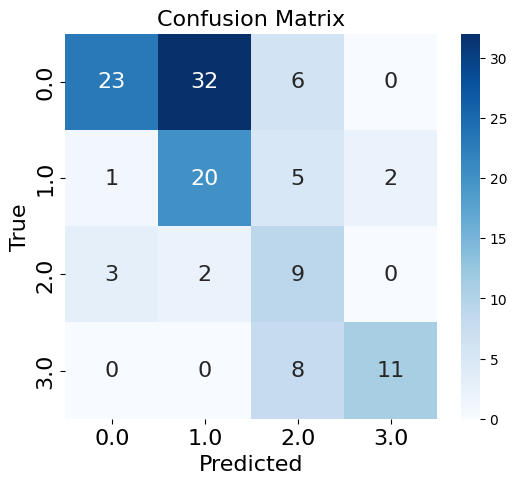

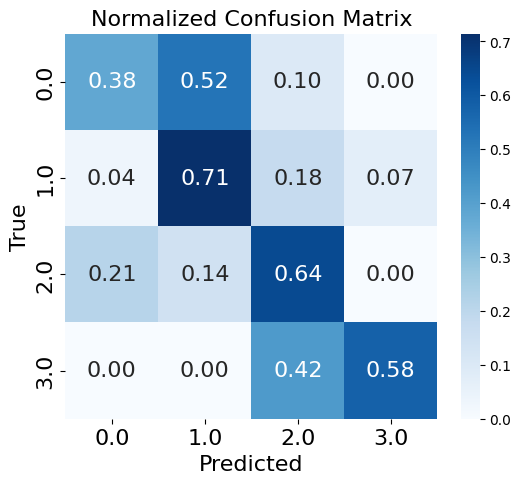

In [65]:
# True labels and predictions
y_true = averaged_data["age_group"].values
y_pred = averaged_data["final_prediction"].values

plot_cm(y_true, y_pred)
plot_cm_norm(y_true, y_pred)

In [57]:
# Use majority voting to define the predicted value for each patient
voted_predictions = averaged_data.groupby('patient_id')['final_prediction'].apply(lambda x: x.mode()[0])

# # Merge the voted predictions back to the original DataFrame
df_voted = averaged_data.drop('final_prediction', axis=1).merge(voted_predictions, on='patient_id', how='left')
df_voted = df_voted.drop_duplicates("patient_id")
MAE = np.abs(df_voted["age_group"].values - df_voted["final_prediction"].values).mean()
print(f'Mean Absolute Error (MAE): {MAE}')

Mean Absolute Error (MAE): 0.5899923333221212


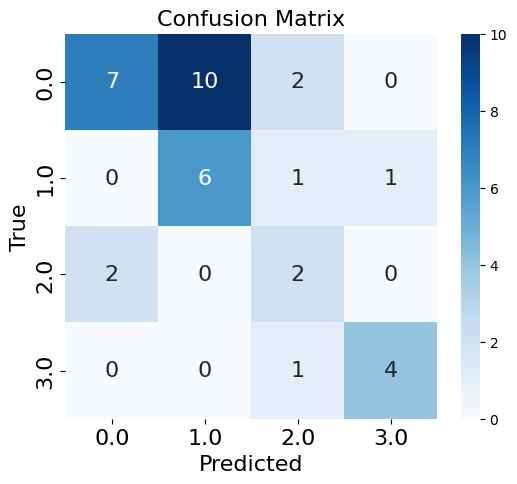

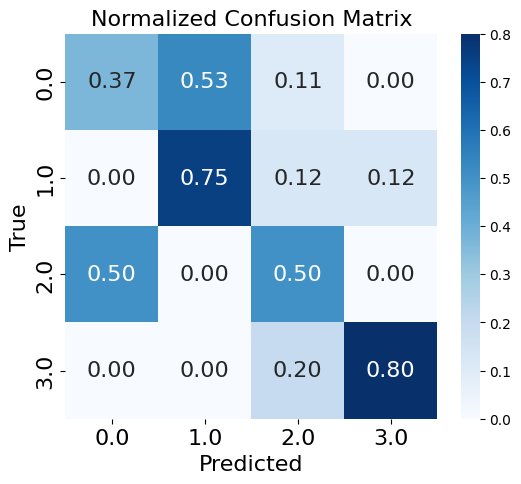

In [66]:
y_true = df_voted["age_group"].values
y_pred = df_voted["final_prediction"].values

plot_cm(y_true, y_pred)
plot_cm_norm(y_true, y_pred)

In [75]:
averaged_data["patient_id"] = [i.replace(".0", "") for i in list(averaged_data["patient_id"])]
averaged_data

,wsi_id,patient_id,cohort,source,age,age_group,branch_0,branch_1,branch_2,sigmoid_0,sigmoid_1,sigmoid_2,binary_0,binary_1,binary_2,final_prediction
0,17064108_FPE_3,17064108,KHP,RM,29.0,0.0,-0.114657,-1.054836,-6.016745,0.471367,0.258297,0.002432,0,0,0,0
250,17064108_FPE_4,17064108,KHP,RM,29.0,0.0,-0.136174,-0.366666,-4.847438,0.466009,0.409347,0.007787,0,0,0,0
500,17064108_FPE_2,17064108,KHP,RM,29.0,0.0,-0.085772,-1.570717,-5.459953,0.478570,0.172114,0.004236,0,0,0,0
750,17064108_FPE_1,17064108,KHP,RM,29.0,0.0,0.100617,-0.836838,-5.992000,0.525133,0.302201,0.002492,1,0,0,1
1000,17064108_FPE_5,17064108,KHP,RM,29.0,0.0,0.203724,-1.009123,-4.647745,0.550756,0.267152,0.009492,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22444,19004666_FPE_3,19004666,KHP,RM,41.0,1.0,1.672026,-0.877469,-2.385076,0.841846,0.293703,0.084318,1,0,0,1
22694,19004618_FPE_2,19004618,KHP,RM,42.0,1.0,3.445453,2.216579,0.769213,0.969095,0.901728,0.683351,1,1,1,3
22944,19004618_FPE_3,19004618,KHP,RM,42.0,1.0,2.697015,0.758666,-1.052460,0.936850,0.681064,0.258753,1,1,0,2
23194,19004618_FPE_1,19004618,KHP,RM,42.0,1.0,3.391697,2.283114,1.682785,0.967444,0.907469,0.843273,1,1,1,3


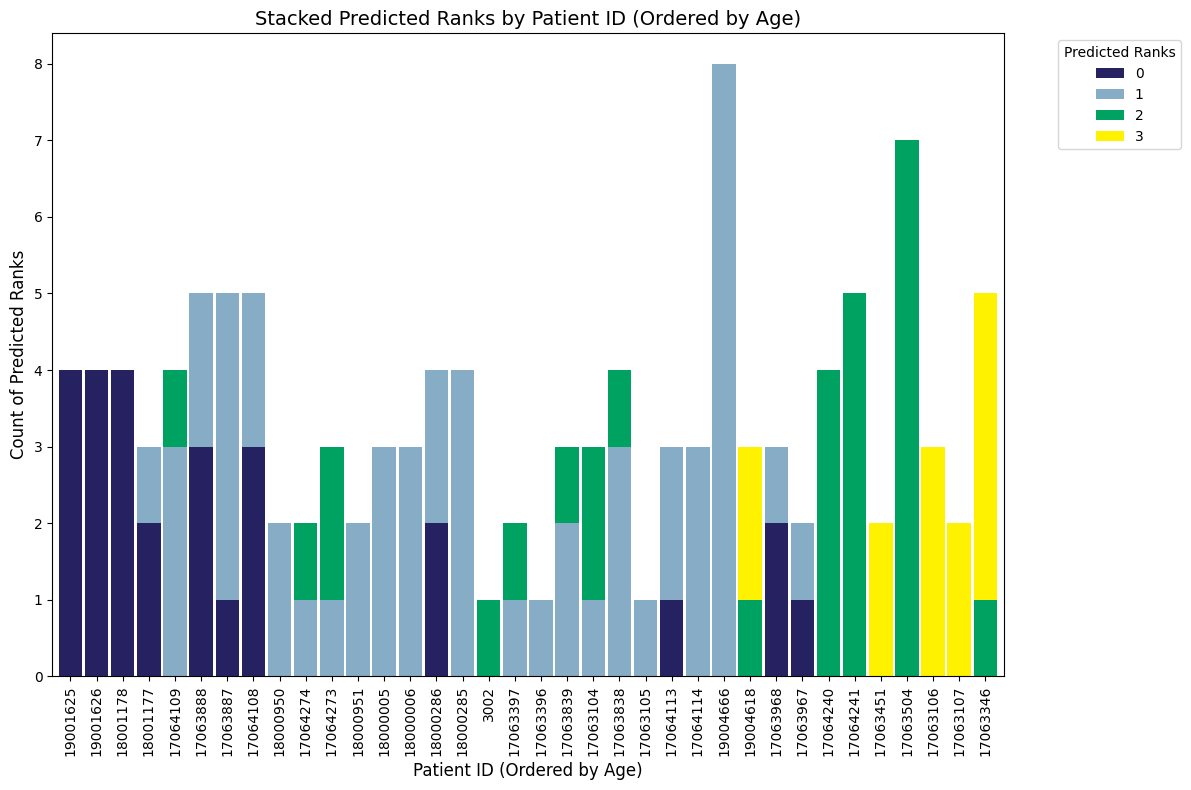

In [78]:
barplot_multiple_WSIs(averaged_data, save_pt=None)